In [1]:
import pandas as pd
import pickle
import itertools
import numpy as np

In [2]:
# read data
path = 'HCC_nojunk.csv'
raw_data = pd.read_csv(path, sep=',') 

In [3]:
# read in SCIMA results
output_name = 'n9_k10_Treg_out_19_33_23'
name = 'Regulatory T cells'
#name = 'M2 Macrophages PD-L1+'
g = pd.read_csv('results_SCIMA/' + output_name + '/analysis/g_1.txt', sep='\t',  header=None)
g.columns = ['AllScore']

# read train/test resuts
testCell_all = list(itertools.chain(*pickle.load(open('results_SCIMA/' + output_name + '/model/test_cell_all.p', 'rb'))))
trainCell_all = list(itertools.chain(*pickle.load(open('results_SCIMA/' + output_name + '/model/train_cell_all.p', 'rb'))))
cellIDs = trainCell_all + testCell_all

# read phnotypes
testCell_pheno = pickle.load(open('results_SCIMA/' + output_name + '/model/test_phen_all.p', 'rb'))
trainCell_pheno = pickle.load(open('results_SCIMA/' + output_name + '/model/train_phen_all.p', 'rb'))
cellPheno = trainCell_pheno + testCell_pheno

In [4]:
obj = pd.DataFrame({'X': cellIDs, 'pheno': cellPheno}) # x- cellIds

In [5]:
uobj = obj.drop_duplicates(subset=['X'])
uobj['NN'] = 1

/tmp/ipykernel_3956903/3344937781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uobj['NN'] = 1


In [6]:
# generate df with data, oheno, NN, g (drop NA)
dumap0 = raw_data.merge(uobj, left_on='X', right_on='X', how='outer')

In [7]:
dumap0['AllScore'] = g
dumap0['NN'] = dumap0['NN'].replace(np.nan, 0)

In [8]:
# Double check t computation!!!
t= np.quantile(np.array(dumap0.AllScore)[np.array(dumap0.NN == 1)], 0.95)

In [9]:
# factor used as in R script
dumap0['filterA'] = list(map(int, dumap0['AllScore'] > t)) # array[0,1] -> 0:false, 1:true
dumap0['filter'] = list(map(int, dumap0['AllScore'] > t))

# change all values in 'filter' to -1 where NN ==0
bool_pos = [i for i, x in enumerate(((dumap0['NN']) == 0).to_list()) if x]
dumap0.loc[bool_pos, 'filter'] =-1

In [10]:
dumap0['tispat'] = (dumap0['Patient'] + ' - ' + dumap0['Tissue']).to_list()

In [11]:
# chose filter
subdf = dumap0.loc[dumap0['filter'].isin([0, 1])]
obj2 = obj.loc[obj['pheno'].isin([2, 1, 0])]

In [12]:
obj2 = obj2.merge(subdf,  left_on='X', right_on='X', suffixes=('_x', ''))

In [13]:
# compute filter frequency
nsel = pd.DataFrame(obj2['tispat'].value_counts())
nsel = nsel.reset_index(level=0)
nsel = nsel.rename({'index': 'tispat', 'tispat' : 'Freq'}, axis='columns')

In [14]:
# choose only filter 1
obj2['bool_1'] = obj2['filter'] ==1
subsel0 = obj2[obj2['bool_1'] == True]
subsel0 = subsel0.drop('bool_1', axis=1)

subsel = pd.DataFrame(subsel0['tispat'].value_counts()).reset_index(level=0)
subsel = subsel.rename({'index' : 'tispat', 'tispat': 'filter'}, axis='columns')

In [15]:
nsel = nsel.merge(subsel, on='tispat', how='left')

In [16]:
nsel['perc'] = (nsel['filter']/nsel['Freq'])*100

In [17]:
phenotypes = pd.DataFrame(dumap0[['tispat', 'Tissue']])
phenotypes = phenotypes.drop_duplicates('tispat')

In [18]:
nsel = nsel.merge(phenotypes, on='tispat', how='left')

In [19]:
subdf = dumap0.loc[dumap0['filter'].isin([1, 0])]
obj2 = obj.loc[obj['pheno'].isin([3])]
obj2 = obj2.merge(subdf, left_on='X', right_on='X',  suffixes=('_x', ''))

In [20]:
nselb = pd.DataFrame(obj2['tispat'].value_counts())
nselb = nselb.reset_index(level=0)
nselb = nselb.rename({'index': 'tispat', 'tispat' : 'Freq'}, axis='columns')

In [21]:
obj2['bool_1'] = obj2['filter'] ==1
subsel0 = obj2[obj2['bool_1'] == True]
subsel0 = subsel0.drop('bool_1', axis=1)

subsel = pd.DataFrame(subsel0['tispat'].value_counts()).reset_index(level=0)
subsel = subsel.rename({'index' : 'tispat', 'tispat': 'filter'}, axis='columns')

In [22]:
nselb = pd.DataFrame(obj2['tispat'].value_counts())
nselb = nselb.reset_index(level=0)
nselb = nselb.rename({'index': 'tispat', 'tispat' : 'Freq'}, axis='columns')


nselb = nselb.merge(subsel, on='tispat', how='left')
nselb['perc'] = (nselb['filter']/nsel['Freq'])*100

In [23]:
phenotypes = pd.DataFrame(dumap0[['tispat', 'Tissue']])
phenotypes = phenotypes.drop_duplicates('tispat')

In [24]:
def names(row):
    if row['Tissue'] == 'normalLiver': 
        return 'BnormalLiver'
    elif row['Tissue'] == 'core':
        return 'Bcore'
    else:
        return 'Brim'

phenotypes['Tissue'] = phenotypes.apply(names, axis=1)

In [25]:
nselb = nselb.merge(phenotypes, on='tispat', how='left')
nselb['perc'] = (nselb['filter']/nsel['Freq'])*100

In [26]:
frames = [nselb, nsel]
nsel0 = pd.concat(frames)

rim v.s. normalLiver: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.468e-01 U_stat=1.560e+02
core v.s. rim: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.390e+02
core v.s. normalLiver: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.212e-02 U_stat=1.830e+02
BnormalLiver v.s. normalLiver: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.145e-04 U_stat=0.000e+00
Brim v.s. rim: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.656e-04 U_stat=1.400e+01
Bcore v.s. core: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.521e-04 U_stat=8.000e+00


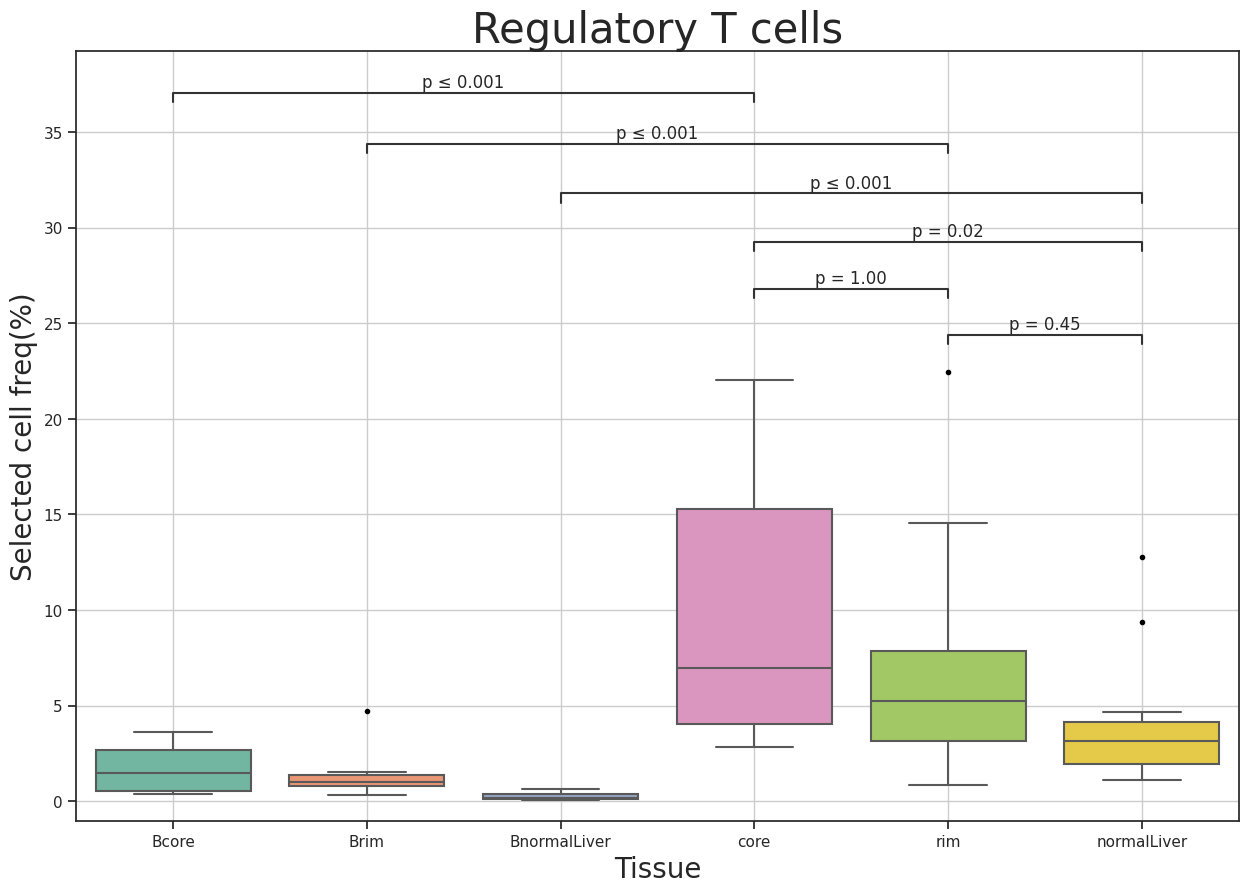

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

plt.figure(figsize=(15,10))
sns.set(style="ticks")

flierprops = dict(marker='o', markerfacecolor='black', markersize=3,  markeredgecolor='black')
ax = sns.boxplot(y = nsel0['perc'], 
                 x = nsel0['Tissue'],
                 flierprops=flierprops,
                 palette = "Set2")
ax.axes.set_title(name,fontsize=30)
#ax.set_yticks([20, 40, 60, 80, 100])
ax.set_xlabel("Tissue",fontsize=20)
ax.set_ylabel("Selected cell freq(%)",fontsize=20)


hue = "smoker"
test_results = add_stat_annotation(ax, data=nsel0, x="Tissue", y="perc", 
                    box_pairs=[
                        ("BnormalLiver", "normalLiver"), ("Brim", "rim"), ("Bcore", "core"),
                        ("normalLiver", "rim"), ("normalLiver", "core"), ("rim", "core")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2,)


test_results
plt.grid()
plt.savefig(output_name + ".png");